In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!ls /kaggle/input/gotennet-required-libraries

aiohappyeyeballs-2.6.1-py3-none-any.whl
aiohttp-3.11.18-cp311-cp311-win_amd64.whl
aiosignal-1.3.2-py2.py3-none-any.whl
attrs-25.3.0-py3-none-any.whl
certifi-2025.4.26-py3-none-any.whl
charset_normalizer-3.4.2-cp311-cp311-win_amd64.whl
colorama-0.4.6-py2.py3-none-any.whl
e3nn-0.5.6-py3-none-any.whl
egnn_pytorch-0.2.8-py3-none-any.whl
einops-0.8.1-py3-none-any.whl
einx-0.3.0-py3-none-any.whl
filelock-3.18.0-py3-none-any.whl
frozendict-2.4.6-py311-none-any.whl
frozenlist-1.6.0-cp311-cp311-win_amd64.whl
fsspec-2025.3.2-py3-none-any.whl
gotennet_pytorch-0.3.1-py3-none-any.whl
hyper_connections-0.1.15-py3-none-any.whl
idna-3.10-py3-none-any.whl
jaxtyping-0.3.2-py3-none-any.whl
jinja2-3.1.6-py3-none-any.whl
llvmlite-0.44.0-cp311-cp311-win_amd64.whl
loguru-0.7.3-py3-none-any.whl
MarkupSafe-3.0.2-cp311-cp311-win_amd64.whl
mpmath-1.3.0-py3-none-any.whl
multidict-6.4.3-cp311-cp311-win_amd64.whl
multidict-6.4.4-cp311-cp311-win_amd64.whl
networkx-3.4.2-py3-none-any.whl
numba-0.61.2-cp311-cp311-win_

In [3]:
!pip install --no-deps --no-index --find-links=/kaggle/input/gotennet-required-libraries torch_geometric gotennet_pytorch

Looking in links: /kaggle/input/gotennet-required-libraries
Processing /kaggle/input/gotennet-required-libraries/torch_geometric-2.6.1-py3-none-any.whl
Processing /kaggle/input/gotennet-required-libraries/gotennet_pytorch-0.3.1-py3-none-any.whl


In [4]:
!pip install --no-deps --no-index --find-links=/kaggle/input/gotennet-required-libraries e3nn einx opt_einsum_fx jaxtyping hyper_connections x_transformers loguru

Looking in links: /kaggle/input/gotennet-required-libraries
Processing /kaggle/input/gotennet-required-libraries/e3nn-0.5.6-py3-none-any.whl
Processing /kaggle/input/gotennet-required-libraries/einx-0.3.0-py3-none-any.whl
Processing /kaggle/input/gotennet-required-libraries/opt_einsum_fx-0.1.4-py3-none-any.whl
Processing /kaggle/input/gotennet-required-libraries/jaxtyping-0.3.2-py3-none-any.whl
Processing /kaggle/input/gotennet-required-libraries/hyper_connections-0.1.15-py3-none-any.whl
Processing /kaggle/input/gotennet-required-libraries/x_transformers-2.3.5-py3-none-any.whl
Processing /kaggle/input/gotennet-required-libraries/loguru-0.7.3-py3-none-any.whl


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch_geometric.data import Data, DataLoader
import gotennet_pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from torch.optim import AdamW
from gotennet_pytorch import GotenNet
from tqdm import tqdm


# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [6]:
# Define paths to data files
TRAIN_SEQUENCES_PATH = "/kaggle/input/stanford-rna-3d-folding/train_sequences.csv"
TRAIN_LABELS_PATH = "/kaggle/input/stanford-rna-3d-folding/train_labels.csv"
# Load data
train_sequences = pd.read_csv(TRAIN_SEQUENCES_PATH)
train_labels = pd.read_csv(TRAIN_LABELS_PATH)

print(f"Loaded {len(train_sequences)} RNA sequences and {len(train_labels)} nucleotide labels")

Loaded 844 RNA sequences and 137095 nucleotide labels


In [7]:
MAX_SEQ_LEN = 500

In [8]:
# Preprocess data
# 1. Encoding nucleotides
nucleotide_mapping = {'A': 0, 'C': 1, 'G': 2, 'U': 3}
reverse_mapping = {0: 'A', 1: 'C', 2: 'G', 3: 'U'}

In [9]:
# 2. Create feature representation for each nucleotide
def one_hot_encode(nucleotide):
    encoding = [0, 0, 0, 0]
    if nucleotide in nucleotide_mapping:
        encoding[nucleotide_mapping[nucleotide]] = 1
    return encoding

In [10]:
# Function to create a graph from an RNA sequence
def sequence_to_graph(sequence, target_id, labels_df=None, max_connections=MAX_SEQ_LEN):
    """
    Create a graph representation of an RNA sequence.
    
    Args:
        sequence: The RNA sequence
        target_id: Identifier for the RNA
        labels_df: Optional dataframe with 3D coordinate labels
        max_connections: Maximum number of edges to create (to avoid CUDA OOM errors)
        
    Returns:
        PyTorch Geometric Data object
    """
    # One-hot encode each nucleotide
    x = [one_hot_encode(nt) for nt in sequence]
    x = torch.tensor(x, dtype=torch.float)
    
    # Create edges - connect adjacent nucleotides (backbone)
    # and potentially other connections based on domain knowledge
    edges = []
    
    # Always add backbone connections
    for i in range(len(sequence) - 1):
        # Connect to next nucleotide (backbone)
        edges.append([i, i + 1])
        edges.append([i + 1, i])  # Bidirectional
    
    # Add potential base-pairing connections, but limit total edges to avoid OOM
    edge_count = len(edges)
    max_additional_edges = max_connections - edge_count
    
    if max_additional_edges > 0:
        potential_base_pairs = []
        
        # Identify potential base pairs (A-U, G-C)
        for i in range(len(sequence)):
            for j in range(i + 3, len(sequence)):  # Minimum loop size of 3
                if (sequence[i] == 'A' and sequence[j] == 'U') or \
                   (sequence[i] == 'U' and sequence[j] == 'A') or \
                   (sequence[i] == 'G' and sequence[j] == 'C') or \
                   (sequence[i] == 'C' and sequence[j] == 'G'):
                    # Store the potential base pair
                    potential_base_pairs.append((i, j))
        
        # Randomly select base pairs if we have too many
        if len(potential_base_pairs) > max_additional_edges // 2:  # Divide by 2 for bidirectional edges
            # Shuffle and take only what we can handle
            random.shuffle(potential_base_pairs)
            potential_base_pairs = potential_base_pairs[:max_additional_edges // 2]
        
        # Add the selected base pairs
        for i, j in potential_base_pairs:
            edges.append([i, j])
            edges.append([j, i])  # Bidirectional
    
    # Convert edges to tensor
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    # Get coordinates if available
    y = None
    mask = None
    if labels_df is not None:
        target_labels = labels_df[labels_df['ID'].str.startswith(target_id + '_')]
        
        # Sort by residue ID to match sequence order
        target_labels = target_labels.sort_values(by='resid')
        
        # Check if we have the expected number of residues
        if len(target_labels) == len(sequence):
            # Extract coordinates for each residue
            coordinates = target_labels[['x_1', 'y_1', 'z_1']].values
            
            # Create a mask for NaN values (1 for valid, 0 for NaN)
            valid_mask = ~np.isnan(coordinates).any(axis=1)
            mask = torch.tensor(valid_mask, dtype=torch.float)
            
            # Replace NaN with zeros (we'll mask these during loss calculation)
            coordinates = np.nan_to_num(coordinates, nan=0.0)
            
            y = torch.tensor(coordinates, dtype=torch.float)
        else:
            print(f"Warning: Mismatch in sequence length and label count for {target_id}")
    
    # Create the data object with properly typed target_id (as string)
    data = Data(x=x, edge_index=edge_index, y=y, mask=mask)
    
    # Store target_id as a string attribute
    data.target_id = str(target_id)
    
    return data

In [11]:
def create_dataset(sequences_df, labels_df=None):
    dataset = []
    skipped_count = 0
    nan_count = 0
    
    for idx, row in tqdm(sequences_df.iterrows(), total=len(sequences_df)):
        target_id = row['target_id']
        sequence = row['sequence']
        
        # Clean sequence - replace any non-standard nucleotides with 'N'
        # and count how many non-standard nucleotides there are
        cleaned_sequence = ''
        non_standard_count = 0
        
        for nt in sequence:
            if nt in nucleotide_mapping:
                cleaned_sequence += nt
            else:
                cleaned_sequence += 'N'  # Placeholder for non-standard nucleotides
                non_standard_count += 1
        
        # If too many non-standard nucleotides (>10%), skip this sequence
        if non_standard_count / len(sequence) > 0.1:
            print(f"Skipping sequence {target_id} with {non_standard_count} non-standard nucleotides")
            skipped_count += 1
            continue
        
        # Create graph
        graph = sequence_to_graph(cleaned_sequence, target_id, labels_df)
        
        # Check if we have labels with many NaN values
        if labels_df is not None and hasattr(graph, 'mask') and graph.mask is not None:
            nan_percentage = 1.0 - torch.mean(graph.mask).item()
            if nan_percentage > 0.5:  # If more than 50% coordinates are NaN
                print(f"Warning: Sequence {target_id} has {nan_percentage:.1%} NaN coordinates")
                nan_count += 1
        
        # Add to dataset if no labels needed or valid labels exist
        if labels_df is None or graph.y is not None:
            dataset.append(graph)
    
    print(f"Dataset creation: {skipped_count} sequences skipped due to non-standard nucleotides")
    print(f"Dataset creation: {nan_count} sequences have >50% NaN coordinates")
    
    return dataset

In [12]:
data={
      "sequence":train_sequences['sequence'].to_list(),
      "temporal_cutoff": train_sequences['temporal_cutoff'].to_list(),
      "description": train_sequences['description'].to_list(),
      "all_sequences": train_sequences['all_sequences'].to_list(),
}
config = {
    "cutoff_date": "2020-01-01",
    "test_cutoff_date": "2022-05-01",
}

In [13]:
# Split data into train and test
all_index = np.arange(len(data['sequence']))
cutoff_date = pd.Timestamp(config['cutoff_date'])
test_cutoff_date = pd.Timestamp(config['test_cutoff_date'])
train_index = [i for i, d in enumerate(data['temporal_cutoff']) if pd.Timestamp(d) <= cutoff_date]
test_index = [i for i, d in enumerate(data['temporal_cutoff']) if pd.Timestamp(d) > cutoff_date and pd.Timestamp(d) <= test_cutoff_date]

In [14]:
# Create training dataset
train_dataset = create_dataset(train_sequences, train_labels)
print(f"Created {len(train_dataset)} graph data objects for training")

 14%|█▎        | 115/844 [00:03<00:20, 35.32it/s]

 16%|█▌        | 135/844 [00:03<00:20, 35.39it/s]

 17%|█▋        | 143/844 [00:04<00:19, 35.22it/s]

 20%|█▉        | 167/844 [00:04<00:20, 32.39it/s]

 21%|██        | 179/844 [00:05<00:20, 33.20it/s]

 22%|██▏       | 187/844 [00:05<00:19, 34.07it/s]

 25%|██▌       | 211/844 [00:06<00:18, 35.02it/s]

 26%|██▌       | 219/844 [00:06<00:17, 35.03it/s]

 28%|██▊       | 235/844 [00:06<00:17, 34.80it/s]

 29%|██▉       | 247/844 [00:07<00:17, 34.23it/s]

 34%|███▎      | 283/844 [00:08<00:16, 33.17it/s]

 36%|███▋      | 307/844 [00:08<00:15, 34.63it/s]

 37%|███▋      | 315/844 [00:09<00:15, 34.49it/s]

 41%|████      | 347/844 [00:10<00:14, 34.36it/s]

 51%|█████     | 427/844 [00:12<00:12, 32.97it/s]

 52%|█████▏    | 443/844 [00:13<00:16, 24.83it/s]

 54%|█████▎    | 453/844 [00:13<00:14, 27.21it/s]

 54%|█████▍    | 457/844 [00:13<00:13, 28.58it/s]

 55%|█████▌    | 465/844 [00:13<00:12, 31.54it/s]

 60%|██████    | 509/844 [00:15<00:09, 34.22it/s]

 69%|██████▉   | 581/844 [00:17<00:07, 34.70it/s]

 71%|███████   | 597/844 [00:17<00:07, 34.57it/s]

 73%|███████▎  | 617/844 [00:18<00:06, 34.15it/s]

 76%|███████▋  | 645/844 [00:19<00:05, 33.76it/s]

 80%|████████  | 677/844 [00:20<00:04, 34.07it/s]

 82%|████████▏ | 693/844 [00:20<00:04, 34.31it/s]

 93%|█████████▎| 789/844 [00:23<00:01, 33.83it/s]

 96%|█████████▌| 809/844 [00:23<00:01, 32.87it/s]

100%|██████████| 844/844 [00:25<00:00, 33.74it/s]

Dataset creation: 0 sequences skipped due to non-standard nucleotides
Dataset creation: 69 sequences have >50% NaN coordinates
Created 844 graph data objects for training


In [15]:
train_graphs = train_dataset[:len(train_index)]
val_graphs = train_dataset[:len(train_index)]
train_graphs = [g for g in train_graphs if g.num_nodes <= MAX_SEQ_LEN]
val_graphs = [g for g in val_graphs if g.num_nodes <= MAX_SEQ_LEN]

## Visualize 

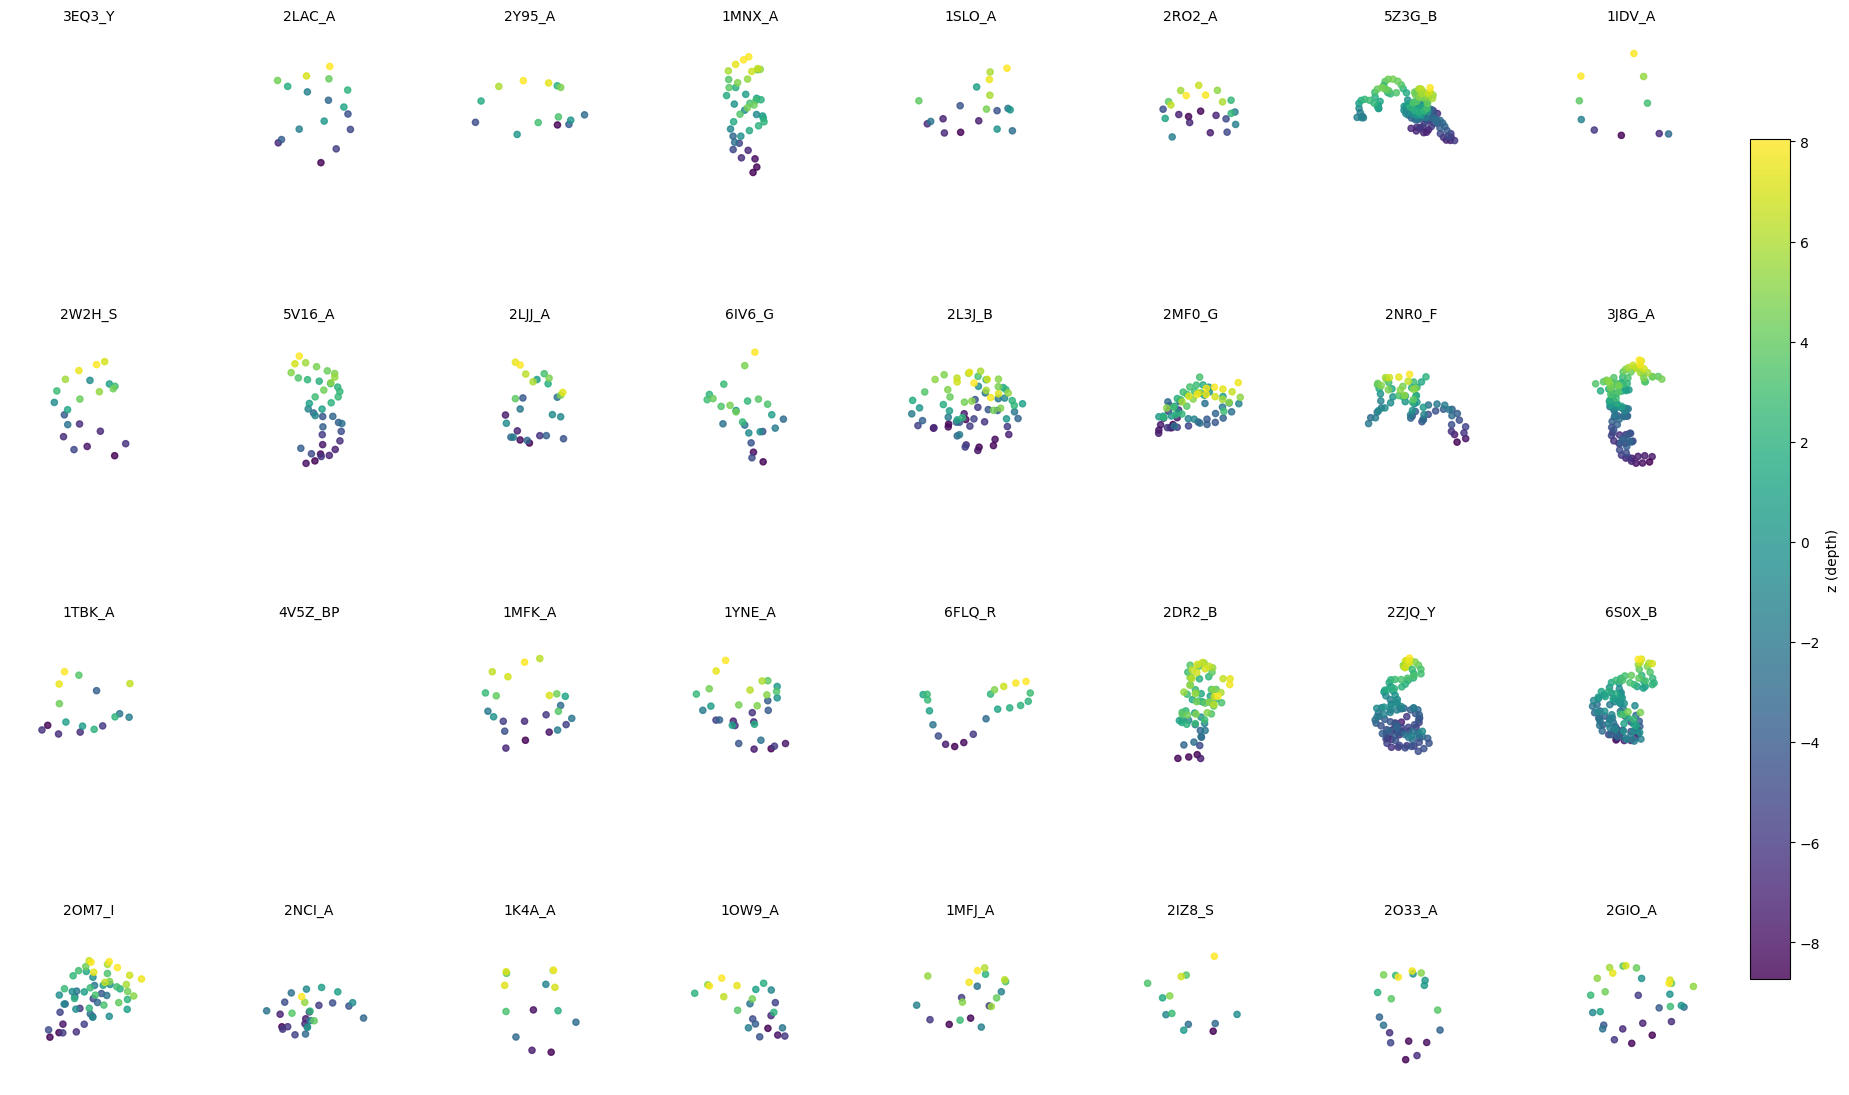

In [16]:
# Get unique target_ids from the dataset
all_target_ids = [data.target_id for data in train_graphs]
unique_target_ids = list(set(all_target_ids))

# Randomly sample 32 unique target_ids
selected_target_ids = np.random.choice(unique_target_ids, size=32, replace=False)

# Create 4x8 grid of subplots
fig, axes = plt.subplots(4, 8, figsize=(20, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

for i, target_id in enumerate(selected_target_ids):
    axes[i].axis('off')

    # Find the corresponding graph in the dataset
    graph = next((g for g in train_dataset if g.target_id == target_id), None)
    
    if graph is None or graph.y is None:
        continue

    coords = graph.y.numpy()
    valid_mask = graph.mask.numpy().astype(bool) if graph.mask is not None else np.ones(len(coords), dtype=bool)

    x = coords[valid_mask, 0]
    y = coords[valid_mask, 1]
    z = coords[valid_mask, 2]

    sc = axes[i].scatter(x, y, z, c=z, cmap='viridis', alpha=0.8)
    axes[i].view_init(elev=30, azim=45)
    axes[i].set_title(f'{target_id}', fontsize=10, pad=10)

# Add shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cbar_ax, label='z (depth)', orientation='vertical')

# Adjust layout
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.4, hspace=0.6)

# Show plot
plt.show()

## Gotennet

In [17]:
# Define loss function for 3D coordinate prediction
def rmsd_loss(pred, target, mask=None):
    """
    Root Mean Square Deviation (RMSD) loss function with optional masking for NaN values.
    Lower RMSD indicates better structural similarity.
    
    Args:
        pred: Predicted coordinates, shape (n_nucleotides, 3)
        target: Target coordinates, shape (n_nucleotides, 3)
        mask: Optional mask for valid values, shape (n_nucleotides,)
    """
    squared_diff = torch.sum((pred - target) ** 2, dim=1)
    
    if mask is not None:
        # Apply mask to consider only valid coordinates
        # Ensure we don't divide by zero by adding a small epsilon to the sum
        masked_squared_diff = squared_diff * mask
        mean_squared_diff = torch.sum(masked_squared_diff) / (torch.sum(mask) + 1e-10)
    else:
        mean_squared_diff = torch.mean(squared_diff)
    
    rmsd = torch.sqrt(mean_squared_diff)
    return rmsd

In [18]:
def calculate_distance_matrix(X,Y,epsilon=1e-4):
    return (torch.square(X[:,None]-Y[None,:])+epsilon).sum(-1).sqrt()


def dRMSD(pred_x,
          pred_y,
          gt_x,
          gt_y,
          epsilon=1e-4,Z=10,d_clamp=None):
    pred_dm=calculate_distance_matrix(pred_x,pred_y)
    gt_dm=calculate_distance_matrix(gt_x,gt_y)



    mask=~torch.isnan(gt_dm)
    mask[torch.eye(mask.shape[0]).bool()]=False

    if d_clamp is not None:
        rmsd=(torch.square(pred_dm[mask]-gt_dm[mask])+epsilon).clip(0,d_clamp**2)
    else:
        rmsd=torch.square(pred_dm[mask]-gt_dm[mask])+epsilon

    return rmsd.sqrt().mean()/Z

def local_dRMSD(pred_x,
          pred_y,
          gt_x,
          gt_y,
          epsilon=1e-4,Z=10,d_clamp=30):
    pred_dm=calculate_distance_matrix(pred_x,pred_y)
    gt_dm=calculate_distance_matrix(gt_x,gt_y)



    mask=(~torch.isnan(gt_dm))*(gt_dm<d_clamp)
    mask[torch.eye(mask.shape[0]).bool()]=False



    rmsd=torch.square(pred_dm[mask]-gt_dm[mask])+epsilon
    # rmsd=(torch.square(pred_dm[mask]-gt_dm[mask])+epsilon).sqrt()/Z
    #rmsd=torch.abs(pred_dm[mask]-gt_dm[mask])/Z
    return rmsd.sqrt().mean()/Z

def dRMAE(pred_x,
          pred_y,
          gt_x,
          gt_y,
          epsilon=1e-4,Z=10,d_clamp=None):
    pred_dm=calculate_distance_matrix(pred_x,pred_y)
    gt_dm=calculate_distance_matrix(gt_x,gt_y)



    mask=~torch.isnan(gt_dm)
    mask[torch.eye(mask.shape[0]).bool()]=False

    rmsd=torch.abs(pred_dm[mask]-gt_dm[mask])

    return rmsd.mean()/Z

def align_svd_mae(input, target, Z=10):
    """
    Aligns the input (Nx3) to target (Nx3) using SVD-based Procrustes alignment
    and computes RMSD loss.
    
    Args:
        input (torch.Tensor): Nx3 tensor representing the input points.
        target (torch.Tensor): Nx3 tensor representing the target points.
    
    Returns:
        aligned_input (torch.Tensor): Nx3 aligned input.
        rmsd_loss (torch.Tensor): RMSD loss.
    """
    assert input.shape == target.shape, "Input and target must have the same shape"

    #mask 
    mask=~torch.isnan(target.sum(-1))

    input=input[mask]
    target=target[mask]
    
    # Compute centroids
    centroid_input = input.mean(dim=0, keepdim=True)
    centroid_target = target.mean(dim=0, keepdim=True)

    # Center the points
    input_centered = input - centroid_input.detach()
    target_centered = target - centroid_target

    # Compute covariance matrix
    cov_matrix = input_centered.T @ target_centered

    # SVD to find optimal rotation
    U, S, Vt = torch.svd(cov_matrix)

    # Compute rotation matrix
    R = Vt @ U.T

    # Ensure a proper rotation (det(R) = 1, no reflection)
    if torch.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt @ U.T

    # Rotate input
    aligned_input = (input_centered @ R.T.detach()) + centroid_target.detach()

    # # Compute RMSD loss
    # rmsd_loss = torch.sqrt(((aligned_input - target) ** 2).mean())

    # rmsd_loss = torch.sqrt(((aligned_input - target) ** 2).mean())
    
    # return aligned_input, rmsd_loss
    return torch.abs(aligned_input-target).mean()/Z

In [19]:
# ----------- Model Wrapper -----------
class GotenNetRNA(nn.Module):
    def __init__(self, num_atom_types=4, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(num_atom_types, hidden_dim)

        self.model = GotenNet(
            dim=hidden_dim,
            max_degree=2,
            depth=1,
            heads=2,
            dim_head=32,
            dim_edge_refinement=hidden_dim,
            return_coors=False
        )

        self.output_proj = nn.Linear(hidden_dim, 3)

    def forward(self, data):
        atom_ids = torch.argmax(data.x, dim=1).unsqueeze(0)  # (1, N)
        N = atom_ids.size(1)
        device = atom_ids.device

        adj = torch.zeros((1, N, N), dtype=torch.bool, device=device)
        src, dst = data.edge_index
        adj[0, src, dst] = 1

        coors = torch.zeros((1, N, 3), device=device)  # dummy input

        invariant, _ = self.model(atom_ids, adj_mat=adj, coors=coors)
        out = self.output_proj(invariant)
        return out.squeeze(0)  # (N, 3)

In [20]:
def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    loss_values = []
    # Create tqdm progress bar with loss display
    pbar = tqdm(train_loader, desc='Training')
    
    for data in pbar:
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        pred = model(data)
        
        # Calculate loss if labels exist
        if data.y is not None:
            # Use mask if available
            if hasattr(data, 'mask') and data.mask is not None:
                loss = dRMAE(pred,pred,data.y,data.y) + align_svd_mae(pred, data.y)
                # loss = rmsd_loss(pred, data.y, data.mask)
            else:
                loss = dRMAE(pred,pred,data.y,data.y) + align_svd_mae(pred, data.y)
                # loss = rmsd_loss(pred, data.y)
                
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loss_values.append(loss.item())
            
            # Update progress bar with current loss
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'smooth loss': np.mean(loss_values[-100:])})
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss

def validate(model, val_loader, device):
    model.eval()
    total_loss = 0
    
    # Create tqdm progress bar with loss display
    pbar = tqdm(val_loader, desc='Validation')
    
    with torch.no_grad():
        for data in pbar:
            data = data.to(device)
            pred = model(data)
            
            if data.y is not None:
                # Use mask if available
                if hasattr(data, 'mask') and data.mask is not None:
                    loss = dRMAE(pred,pred,data.y,data.y) + align_svd_mae(pred, data.y)
                    # loss = rmsd_loss(pred, data.y, data.mask)
                else:
                    loss = dRMAE(pred,pred,data.y,data.y) + align_svd_mae(pred, data.y)
                    # loss = rmsd_loss(pred, data.y)
                total_loss += loss.item()
                
                # Update progress bar with current loss
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(val_loader)
    return avg_loss

# Function to make predictions on test data
def predict(model, test_loader, device):
    model.eval()
    predictions = {}
    
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            pred = model(data)
            
            # Store predictions
            target_id = data.target_id
            
            # If we have ground truth and mask, report metrics
            if hasattr(data, 'y') and data.y is not None:
                if hasattr(data, 'mask') and data.mask is not None:
                    loss = rmsd_loss(pred, data.y, data.mask).item()
                else:
                    loss = rmsd_loss(pred, data.y).item()
                print(f"Prediction for {target_id}, RMSD: {loss:.4f}")
            
            predictions[target_id] = pred.cpu().numpy()
    
    return predictions

In [21]:
# ----------- Setup -----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GotenNetRNA().to(device)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
criterion = nn.L1Loss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
num_epochs = 600
batch_size = 1
num_workers = 4
early_stopping_patience = 100
best_val_loss = float("inf")

In [22]:
# Setup for training
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
device = torch.device(device)
print(f"Using device: {device}")

Using device: cuda


In [23]:
# Create data loaders
train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True, num_workers=4)
val_loader = DataLoader(val_graphs, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [24]:
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(1, num_epochs + 1):
    # --- Train ---
    train_loss = train(model, train_loader, optimizer, device)
    train_losses.append(train_loss)

    # --- Validate ---
    val_loss = validate(model, val_loader, device)
    val_losses.append(val_loss)

    # --- Adjust Learning Rate ---
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # --- Check for Improvement ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), "best_rna_structure_model.pt")
    else:
        early_stopping_counter += 1

    # --- Display formatted output ---
    print(f"Epoch {epoch:4d}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"LR: {current_lr:.6f}")

    # --- Early Stopping ---
    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break

print("Training completed.")


Starting training...


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.26it/s, loss=3.2794]


Epoch    1/600, Train Loss: 2.7938, Val Loss: 2.7606, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.18it/s, loss=3.3388]


Epoch    2/600, Train Loss: 2.7621, Val Loss: 2.7347, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.73it/s, loss=3.2460]


Epoch    3/600, Train Loss: 2.7291, Val Loss: 2.7218, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.33it/s, loss=3.1555]


Epoch    4/600, Train Loss: 2.7354, Val Loss: 2.7677, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.02it/s, loss=3.2535]


Epoch    5/600, Train Loss: 2.7456, Val Loss: 2.7012, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.04it/s, loss=3.1796]


Epoch    6/600, Train Loss: 2.7371, Val Loss: 2.7271, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.89it/s, loss=3.2225]


Epoch    7/600, Train Loss: 2.7159, Val Loss: 2.6979, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:11<00:00, 47.98it/s, loss=3.3047]


Epoch    8/600, Train Loss: 2.7052, Val Loss: 2.6900, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.61it/s, loss=3.3997]


Epoch    9/600, Train Loss: 2.6942, Val Loss: 2.7108, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.31it/s, loss=3.1913]


Epoch   10/600, Train Loss: 2.6854, Val Loss: 2.6923, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:11<00:00, 47.98it/s, loss=3.1549]


Epoch   11/600, Train Loss: 2.6749, Val Loss: 2.6588, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.48it/s, loss=3.1421]


Epoch   12/600, Train Loss: 2.6706, Val Loss: 2.6603, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.87it/s, loss=3.3665]


Epoch   13/600, Train Loss: 2.6631, Val Loss: 2.6847, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.86it/s, loss=3.2600]


Epoch   14/600, Train Loss: 2.6669, Val Loss: 2.6507, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.30it/s, loss=3.1985]


Epoch   15/600, Train Loss: 2.6763, Val Loss: 2.6634, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.25it/s, loss=3.1828]


Epoch   16/600, Train Loss: 2.6596, Val Loss: 2.6485, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.31it/s, loss=3.1742]


Epoch   17/600, Train Loss: 2.6582, Val Loss: 2.6398, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.24it/s, loss=3.2934]


Epoch   18/600, Train Loss: 2.6481, Val Loss: 2.6839, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.34it/s, loss=3.1034]


Epoch   19/600, Train Loss: 2.6533, Val Loss: 2.6372, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.44it/s, loss=3.1448]


Epoch   20/600, Train Loss: 2.6509, Val Loss: 2.6280, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.18it/s, loss=3.1667]


Epoch   21/600, Train Loss: 2.6477, Val Loss: 2.6442, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.74it/s, loss=3.1167]


Epoch   22/600, Train Loss: 2.6840, Val Loss: 2.6518, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.89it/s, loss=3.2072]


Epoch   23/600, Train Loss: 2.6577, Val Loss: 2.6285, LR: 0.001000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.29it/s, loss=3.2224]


Epoch   24/600, Train Loss: 2.6512, Val Loss: 2.6344, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.57it/s, loss=3.2287]


Epoch   25/600, Train Loss: 2.6532, Val Loss: 2.6482, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.50it/s, loss=3.1747]


Epoch   26/600, Train Loss: 2.6461, Val Loss: 2.6306, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.77it/s, loss=3.2423]


Epoch   27/600, Train Loss: 2.6233, Val Loss: 2.6298, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.22it/s, loss=3.2037]


Epoch   28/600, Train Loss: 2.6176, Val Loss: 2.6209, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.64it/s, loss=3.1600]


Epoch   29/600, Train Loss: 2.6097, Val Loss: 2.6007, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.35it/s, loss=3.2169]


Epoch   30/600, Train Loss: 2.6194, Val Loss: 2.6296, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:11<00:00, 47.93it/s, loss=3.1005]


Epoch   31/600, Train Loss: 2.6000, Val Loss: 2.5773, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.47it/s, loss=3.0454]


Epoch   32/600, Train Loss: 2.5958, Val Loss: 2.5664, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.65it/s, loss=3.1317]


Epoch   33/600, Train Loss: 2.5872, Val Loss: 2.5709, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.20it/s, loss=3.0657]


Epoch   34/600, Train Loss: 2.5897, Val Loss: 2.5641, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.35it/s, loss=3.2144]


Epoch   35/600, Train Loss: 2.5745, Val Loss: 2.5990, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.81it/s, loss=3.0596]


Epoch   36/600, Train Loss: 2.5728, Val Loss: 2.5574, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.80it/s, loss=3.0534]


Epoch   37/600, Train Loss: 2.5682, Val Loss: 2.5896, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.68it/s, loss=3.0546]


Epoch   38/600, Train Loss: 2.5726, Val Loss: 2.5529, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.02it/s, loss=3.0052]


Epoch   39/600, Train Loss: 2.5632, Val Loss: 2.5428, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.01it/s, loss=3.0225]


Epoch   40/600, Train Loss: 2.5640, Val Loss: 2.5391, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.80it/s, loss=2.9814]


Epoch   41/600, Train Loss: 2.5606, Val Loss: 2.5480, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.90it/s, loss=3.0016]


Epoch   42/600, Train Loss: 2.5549, Val Loss: 2.5401, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.35it/s, loss=3.0542]


Epoch   43/600, Train Loss: 2.5550, Val Loss: 2.5480, LR: 0.000500


Validation: 100%|██████████| 575/575 [00:11<00:00, 49.23it/s, loss=3.0178]


Epoch   44/600, Train Loss: 2.5583, Val Loss: 2.5503, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.10it/s, loss=2.9880]


Epoch   45/600, Train Loss: 2.5397, Val Loss: 2.5241, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.75it/s, loss=3.0114]


Epoch   46/600, Train Loss: 2.5349, Val Loss: 2.5289, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.85it/s, loss=2.9889]


Epoch   47/600, Train Loss: 2.5312, Val Loss: 2.5236, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.63it/s, loss=2.9806]


Epoch   48/600, Train Loss: 2.5358, Val Loss: 2.5231, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.16it/s, loss=2.9970]


Epoch   49/600, Train Loss: 2.5292, Val Loss: 2.5270, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.80it/s, loss=2.9824]


Epoch   50/600, Train Loss: 2.5277, Val Loss: 2.5312, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.83it/s, loss=2.9872]


Epoch   51/600, Train Loss: 2.5240, Val Loss: 2.5184, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.07it/s, loss=2.9730]


Epoch   52/600, Train Loss: 2.5261, Val Loss: 2.5173, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.41it/s, loss=3.0018]


Epoch   53/600, Train Loss: 2.5221, Val Loss: 2.5431, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.36it/s, loss=2.9891]


Epoch   54/600, Train Loss: 2.5237, Val Loss: 2.5138, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:13<00:00, 42.22it/s, loss=2.9728]


Epoch   55/600, Train Loss: 2.5227, Val Loss: 2.5114, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.46it/s, loss=2.9633]


Epoch   56/600, Train Loss: 2.5190, Val Loss: 2.5086, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.94it/s, loss=2.9845]


Epoch   57/600, Train Loss: 2.5227, Val Loss: 2.5077, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.51it/s, loss=3.0032]


Epoch   58/600, Train Loss: 2.5164, Val Loss: 2.5218, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.16it/s, loss=2.9608]


Epoch   59/600, Train Loss: 2.5215, Val Loss: 2.5098, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.34it/s, loss=2.9481]


Epoch   60/600, Train Loss: 2.5175, Val Loss: 2.5024, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.87it/s, loss=2.9688]


Epoch   61/600, Train Loss: 2.5138, Val Loss: 2.5090, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.95it/s, loss=3.0111]


Epoch   62/600, Train Loss: 2.5150, Val Loss: 2.5055, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.00it/s, loss=2.9782]


Epoch   63/600, Train Loss: 2.5100, Val Loss: 2.5027, LR: 0.000250


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.19it/s, loss=2.9613]


Epoch   64/600, Train Loss: 2.5173, Val Loss: 2.5183, LR: 0.000125


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.19it/s, loss=2.9542]


Epoch   65/600, Train Loss: 2.5050, Val Loss: 2.4994, LR: 0.000125


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.16it/s, loss=2.9549]


Epoch   66/600, Train Loss: 2.5016, Val Loss: 2.4995, LR: 0.000125


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.90it/s, loss=2.9714]


Epoch   67/600, Train Loss: 2.5002, Val Loss: 2.4945, LR: 0.000125


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.63it/s, loss=2.9566]


Epoch   68/600, Train Loss: 2.5004, Val Loss: 2.5019, LR: 0.000125


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.01it/s, loss=2.9571]


Epoch   69/600, Train Loss: 2.4983, Val Loss: 2.5002, LR: 0.000125


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.86it/s, loss=2.9576]


Epoch   70/600, Train Loss: 2.5010, Val Loss: 2.4920, LR: 0.000125


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.20it/s, loss=2.9487]


Epoch   71/600, Train Loss: 2.5000, Val Loss: 2.4927, LR: 0.000125


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.10it/s, loss=2.9536]


Epoch   72/600, Train Loss: 2.4995, Val Loss: 2.4903, LR: 0.000125


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.80it/s, loss=2.9621]


Epoch   73/600, Train Loss: 2.5029, Val Loss: 2.4942, LR: 0.000125


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.49it/s, loss=2.9490]


Epoch   74/600, Train Loss: 2.4980, Val Loss: 2.4917, LR: 0.000125


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.50it/s, loss=2.9586]


Epoch   75/600, Train Loss: 2.5002, Val Loss: 2.4916, LR: 0.000125


Validation: 100%|██████████| 575/575 [00:12<00:00, 44.89it/s, loss=2.9725]


Epoch   76/600, Train Loss: 2.4993, Val Loss: 2.4945, LR: 0.000063


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.18it/s, loss=2.9597]


Epoch   77/600, Train Loss: 2.4929, Val Loss: 2.4885, LR: 0.000063


Validation: 100%|██████████| 575/575 [00:12<00:00, 44.82it/s, loss=2.9532]


Epoch   78/600, Train Loss: 2.4909, Val Loss: 2.4866, LR: 0.000063


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.94it/s, loss=2.9564]


Epoch   79/600, Train Loss: 2.4902, Val Loss: 2.4867, LR: 0.000063


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.58it/s, loss=2.9593]


Epoch   80/600, Train Loss: 2.4895, Val Loss: 2.4870, LR: 0.000063


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.46it/s, loss=2.9630]


Epoch   81/600, Train Loss: 2.4913, Val Loss: 2.4857, LR: 0.000063


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.80it/s, loss=2.9515]


Epoch   82/600, Train Loss: 2.4888, Val Loss: 2.4864, LR: 0.000063


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.97it/s, loss=2.9577]


Epoch   83/600, Train Loss: 2.4904, Val Loss: 2.4923, LR: 0.000063


Validation: 100%|██████████| 575/575 [00:12<00:00, 44.32it/s, loss=2.9659]


Epoch   84/600, Train Loss: 2.4889, Val Loss: 2.4898, LR: 0.000063


Validation: 100%|██████████| 575/575 [00:12<00:00, 44.56it/s, loss=2.9492]


Epoch   85/600, Train Loss: 2.4899, Val Loss: 2.4857, LR: 0.000031


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.04it/s, loss=2.9582]


Epoch   86/600, Train Loss: 2.4860, Val Loss: 2.4873, LR: 0.000031


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.77it/s, loss=2.9519]


Epoch   87/600, Train Loss: 2.4864, Val Loss: 2.4835, LR: 0.000031


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.00it/s, loss=2.9495]


Epoch   88/600, Train Loss: 2.4863, Val Loss: 2.4839, LR: 0.000031


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.89it/s, loss=2.9508]


Epoch   89/600, Train Loss: 2.4858, Val Loss: 2.4838, LR: 0.000031


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.26it/s, loss=2.9595]


Epoch   90/600, Train Loss: 2.4849, Val Loss: 2.4843, LR: 0.000031


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.93it/s, loss=2.9500]


Epoch   91/600, Train Loss: 2.4846, Val Loss: 2.4825, LR: 0.000031


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.26it/s, loss=2.9480]


Epoch   92/600, Train Loss: 2.4849, Val Loss: 2.4823, LR: 0.000031


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.56it/s, loss=2.9584]


Epoch   93/600, Train Loss: 2.4842, Val Loss: 2.4836, LR: 0.000031


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.08it/s, loss=2.9515]


Epoch   94/600, Train Loss: 2.4846, Val Loss: 2.4818, LR: 0.000031


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.67it/s, loss=2.9518]


Epoch   95/600, Train Loss: 2.4843, Val Loss: 2.4822, LR: 0.000031


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.36it/s, loss=2.9500]


Epoch   96/600, Train Loss: 2.4842, Val Loss: 2.4839, LR: 0.000031


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.19it/s, loss=2.9456]


Epoch   97/600, Train Loss: 2.4831, Val Loss: 2.4821, LR: 0.000031


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.68it/s, loss=2.9476]


Epoch   98/600, Train Loss: 2.4841, Val Loss: 2.4831, LR: 0.000016


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.63it/s, loss=2.9512]


Epoch   99/600, Train Loss: 2.4833, Val Loss: 2.4812, LR: 0.000016


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.69it/s, loss=2.9488]


Epoch  100/600, Train Loss: 2.4822, Val Loss: 2.4804, LR: 0.000016


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.44it/s, loss=2.9485]


Epoch  101/600, Train Loss: 2.4821, Val Loss: 2.4806, LR: 0.000016


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.92it/s, loss=2.9482]


Epoch  102/600, Train Loss: 2.4822, Val Loss: 2.4810, LR: 0.000016


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.68it/s, loss=2.9495]


Epoch  103/600, Train Loss: 2.4821, Val Loss: 2.4806, LR: 0.000016


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.42it/s, loss=2.9490]


Epoch  104/600, Train Loss: 2.4825, Val Loss: 2.4805, LR: 0.000008


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.52it/s, loss=2.9498]


Epoch  105/600, Train Loss: 2.4805, Val Loss: 2.4801, LR: 0.000008


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.00it/s, loss=2.9491]


Epoch  106/600, Train Loss: 2.4810, Val Loss: 2.4802, LR: 0.000008


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.11it/s, loss=2.9494]


Epoch  107/600, Train Loss: 2.4808, Val Loss: 2.4797, LR: 0.000008


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.52it/s, loss=2.9492]


Epoch  108/600, Train Loss: 2.4806, Val Loss: 2.4802, LR: 0.000008


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.78it/s, loss=2.9486]


Epoch  109/600, Train Loss: 2.4809, Val Loss: 2.4800, LR: 0.000008


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.86it/s, loss=2.9488]


Epoch  110/600, Train Loss: 2.4808, Val Loss: 2.4802, LR: 0.000008


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.56it/s, loss=2.9508]


Epoch  111/600, Train Loss: 2.4806, Val Loss: 2.4800, LR: 0.000004


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.13it/s, loss=2.9498]


Epoch  112/600, Train Loss: 2.4802, Val Loss: 2.4799, LR: 0.000004


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.14it/s, loss=2.9493]


Epoch  113/600, Train Loss: 2.4801, Val Loss: 2.4799, LR: 0.000004


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.09it/s, loss=2.9490]


Epoch  114/600, Train Loss: 2.4803, Val Loss: 2.4794, LR: 0.000004


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.45it/s, loss=2.9492]


Epoch  115/600, Train Loss: 2.4804, Val Loss: 2.4798, LR: 0.000004


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.98it/s, loss=2.9490]


Epoch  116/600, Train Loss: 2.4802, Val Loss: 2.4798, LR: 0.000004


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.57it/s, loss=2.9489]


Epoch  117/600, Train Loss: 2.4802, Val Loss: 2.4797, LR: 0.000004


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.99it/s, loss=2.9487]


Epoch  118/600, Train Loss: 2.4804, Val Loss: 2.4793, LR: 0.000002


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.69it/s, loss=2.9488]


Epoch  119/600, Train Loss: 2.4799, Val Loss: 2.4797, LR: 0.000002


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.84it/s, loss=2.9489]


Epoch  120/600, Train Loss: 2.4799, Val Loss: 2.4796, LR: 0.000002


Validation: 100%|██████████| 575/575 [00:11<00:00, 49.40it/s, loss=2.9490]


Epoch  121/600, Train Loss: 2.4799, Val Loss: 2.4796, LR: 0.000002


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.43it/s, loss=2.9490]


Epoch  122/600, Train Loss: 2.4800, Val Loss: 2.4798, LR: 0.000001


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.22it/s, loss=2.9491]


Epoch  123/600, Train Loss: 2.4799, Val Loss: 2.4798, LR: 0.000001


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.83it/s, loss=2.9491]


Epoch  124/600, Train Loss: 2.4799, Val Loss: 2.4797, LR: 0.000001


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.26it/s, loss=2.9491]


Epoch  125/600, Train Loss: 2.4798, Val Loss: 2.4797, LR: 0.000001


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.97it/s, loss=2.9492]


Epoch  126/600, Train Loss: 2.4798, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 49.02it/s, loss=2.9492]


Epoch  127/600, Train Loss: 2.4796, Val Loss: 2.4798, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.81it/s, loss=2.9492]


Epoch  128/600, Train Loss: 2.4798, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 49.05it/s, loss=2.9492]


Epoch  129/600, Train Loss: 2.4798, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.01it/s, loss=2.9492]


Epoch  130/600, Train Loss: 2.4798, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.46it/s, loss=2.9492]


Epoch  131/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 44.81it/s, loss=2.9492]


Epoch  132/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.61it/s, loss=2.9492]


Epoch  133/600, Train Loss: 2.4798, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 44.94it/s, loss=2.9492]


Epoch  134/600, Train Loss: 2.4798, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.54it/s, loss=2.9492]


Epoch  135/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.63it/s, loss=2.9492]


Epoch  136/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.39it/s, loss=2.9492]


Epoch  137/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.55it/s, loss=2.9492]


Epoch  138/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 47.92it/s, loss=2.9492]


Epoch  139/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.81it/s, loss=2.9492]


Epoch  140/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.49it/s, loss=2.9492]


Epoch  141/600, Train Loss: 2.4797, Val Loss: 2.4796, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.48it/s, loss=2.9492]


Epoch  142/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.84it/s, loss=2.9492]


Epoch  143/600, Train Loss: 2.4797, Val Loss: 2.4796, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.64it/s, loss=2.9492]


Epoch  144/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.78it/s, loss=2.9492]


Epoch  145/600, Train Loss: 2.4797, Val Loss: 2.4796, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.17it/s, loss=2.9492]


Epoch  146/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.45it/s, loss=2.9492]


Epoch  147/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.78it/s, loss=2.9491]


Epoch  148/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 47.99it/s, loss=2.9491]


Epoch  149/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.08it/s, loss=2.9491]


Epoch  150/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.11it/s, loss=2.9491]


Epoch  151/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.25it/s, loss=2.9491]


Epoch  152/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 49.03it/s, loss=2.9491]


Epoch  153/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.83it/s, loss=2.9491]


Epoch  154/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.71it/s, loss=2.9491]


Epoch  155/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.63it/s, loss=2.9491]


Epoch  156/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 49.05it/s, loss=2.9491]


Epoch  157/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.17it/s, loss=2.9491]


Epoch  158/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.47it/s, loss=2.9491]


Epoch  159/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.76it/s, loss=2.9491]


Epoch  160/600, Train Loss: 2.4797, Val Loss: 2.4796, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.74it/s, loss=2.9491]


Epoch  161/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.15it/s, loss=2.9491]


Epoch  162/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.86it/s, loss=2.9491]


Epoch  163/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.88it/s, loss=2.9491]


Epoch  164/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 49.14it/s, loss=2.9491]


Epoch  165/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 49.22it/s, loss=2.9491]


Epoch  166/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 49.24it/s, loss=2.9491]


Epoch  167/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.82it/s, loss=2.9491]


Epoch  168/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.20it/s, loss=2.9491]


Epoch  169/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.25it/s, loss=2.9491]


Epoch  170/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.46it/s, loss=2.9491]


Epoch  171/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.11it/s, loss=2.9491]


Epoch  172/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.85it/s, loss=2.9491]


Epoch  173/600, Train Loss: 2.4797, Val Loss: 2.4796, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 49.00it/s, loss=2.9491]


Epoch  174/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.10it/s, loss=2.9491]


Epoch  175/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 49.00it/s, loss=2.9491]


Epoch  176/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.89it/s, loss=2.9491]


Epoch  177/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.50it/s, loss=2.9491]


Epoch  178/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 44.55it/s, loss=2.9491]


Epoch  179/600, Train Loss: 2.4797, Val Loss: 2.4796, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.61it/s, loss=2.9491]


Epoch  180/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.58it/s, loss=2.9491]


Epoch  181/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 47.99it/s, loss=2.9491]


Epoch  182/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.68it/s, loss=2.9491]


Epoch  183/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.43it/s, loss=2.9491]


Epoch  184/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.62it/s, loss=2.9491]


Epoch  185/600, Train Loss: 2.4797, Val Loss: 2.4796, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 49.06it/s, loss=2.9491]


Epoch  186/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.45it/s, loss=2.9491]


Epoch  187/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.06it/s, loss=2.9491]


Epoch  188/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.87it/s, loss=2.9491]


Epoch  189/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.09it/s, loss=2.9491]


Epoch  190/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.62it/s, loss=2.9491]


Epoch  191/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.67it/s, loss=2.9491]


Epoch  192/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.29it/s, loss=2.9491]


Epoch  193/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.84it/s, loss=2.9491]


Epoch  194/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.95it/s, loss=2.9491]


Epoch  195/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 49.09it/s, loss=2.9491]


Epoch  196/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 45.17it/s, loss=2.9491]


Epoch  197/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 47.97it/s, loss=2.9491]


Epoch  198/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.32it/s, loss=2.9491]


Epoch  199/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.21it/s, loss=2.9491]


Epoch  200/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.09it/s, loss=2.9491]


Epoch  201/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.70it/s, loss=2.9491]


Epoch  202/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 49.22it/s, loss=2.9491]


Epoch  203/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 49.12it/s, loss=2.9491]


Epoch  204/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.84it/s, loss=2.9491]


Epoch  205/600, Train Loss: 2.4795, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 49.37it/s, loss=2.9491]


Epoch  206/600, Train Loss: 2.4797, Val Loss: 2.4797, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.64it/s, loss=2.9491]


Epoch  207/600, Train Loss: 2.4795, Val Loss: 2.4795, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.49it/s, loss=2.9491]


Epoch  208/600, Train Loss: 2.4797, Val Loss: 2.4795, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.31it/s, loss=2.9491]


Epoch  209/600, Train Loss: 2.4795, Val Loss: 2.4795, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.42it/s, loss=2.9491]


Epoch  210/600, Train Loss: 2.4795, Val Loss: 2.4795, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.80it/s, loss=2.9491]


Epoch  211/600, Train Loss: 2.4795, Val Loss: 2.4795, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.90it/s, loss=2.9491]


Epoch  212/600, Train Loss: 2.4796, Val Loss: 2.4795, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.77it/s, loss=2.9491]


Epoch  213/600, Train Loss: 2.4796, Val Loss: 2.4795, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.19it/s, loss=2.9491]


Epoch  214/600, Train Loss: 2.4795, Val Loss: 2.4795, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 49.33it/s, loss=2.9491]


Epoch  215/600, Train Loss: 2.4796, Val Loss: 2.4795, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:11<00:00, 48.45it/s, loss=2.9491]


Epoch  216/600, Train Loss: 2.4795, Val Loss: 2.4795, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 46.80it/s, loss=2.9491]


Epoch  217/600, Train Loss: 2.4795, Val Loss: 2.4795, LR: 0.000000


Validation: 100%|██████████| 575/575 [00:12<00:00, 47.13it/s, loss=2.9491]

Epoch  218/600, Train Loss: 2.4795, Val Loss: 2.4795, LR: 0.000000
Early stopping triggered at epoch 218
Training completed.


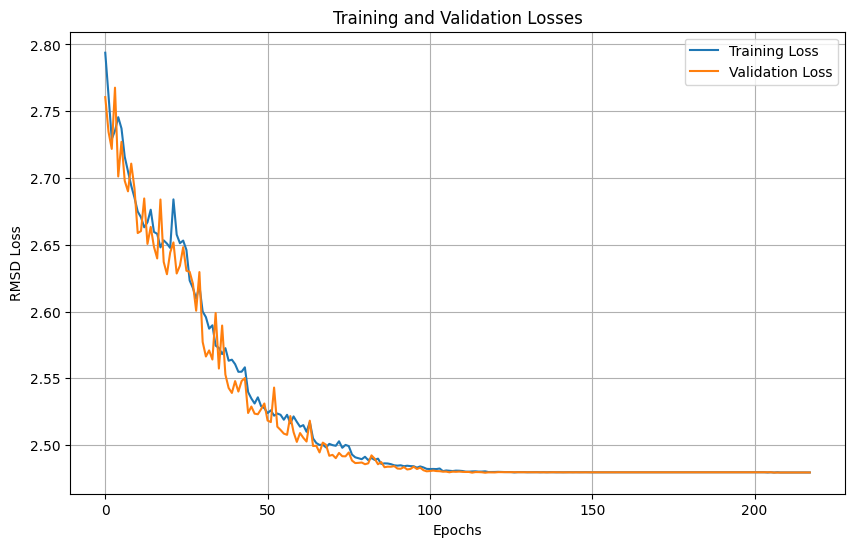

In [25]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('RMSD Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Generate multiple conformations for each RNA sequence
def generate_multiple_conformations(model, data, num_conformations=5):
    """
    Generate multiple structural conformations for an RNA sequence.
    
    Args:
        model: The trained GNN model
        data: Graph data object containing the RNA sequence
        num_conformations: Number of conformations to generate (default: 5)
        
    Returns:
        List of numpy arrays, each array has shape (n_nucleotides, 3) for x,y,z coordinates
    """
    model.eval()
    conformations = []
    
    # Set random seed for reproducibility
    torch.manual_seed(42)
    
    with torch.no_grad():
        # Generate first conformation (deterministic)
        base_pred = model(data)
        base_np = base_pred.cpu().numpy()
        
        # Check if base prediction contains NaN values
        if np.isnan(base_np).any():
            print("Warning: Base prediction contains NaN values. Replacing with zeros.")
            base_np = np.nan_to_num(base_np, nan=0.0)
        
        # Save the base prediction
        conformations.append(base_np)
        
        # Generate additional conformations with controlled variations
        for i in range(1, num_conformations):
            # Use different seeds for different conformations
            torch.manual_seed(42 + i * 100)  # Larger seed increment for more diversity
            
            # Create a copy of the base prediction with a small, controlled variation
            variation = base_np.copy()
            
            # Add random noise with small magnitude (1-5% of the coordinate values)
            # Calculate standard deviation of base coordinates to scale noise appropriately
            if not np.all(base_np == 0):  # Check if base_np is not all zeros
                coord_std = max(np.std(base_np), 0.5)  # Use at least 0.5 to avoid too small noise
                noise_scale = coord_std * 0.05 * (i + 1)  # Increasing noise for each conformation
            else:
                # If base prediction is all zeros (which shouldn't happen normally)
                noise_scale = 0.5 * (i + 1)
            
            # Generate noise and ensure it's not NaN
            noise = np.random.normal(0, noise_scale, size=variation.shape)
            
            # Apply noise to create a new conformation
            variation += noise
            
            # Ensure no NaN values
            variation = np.nan_to_num(variation, nan=0.0)
            
            conformations.append(variation)
    
    # Double-check that all conformations are valid and contain no NaNs
    for i, conf in enumerate(conformations):
        if np.isnan(conf).any():
            print(f"Warning: Conformation {i+1} contains NaN values after processing. Replacing with zeros.")
            conformations[i] = np.nan_to_num(conf, nan=0.0)
    
    return conformations

# Function to make multiple predictions for test data
def predict_multiple_conformations(model, test_loader, device, num_conformations=5):
    predictions = {}
    
    for data in test_loader:
        data = data.to(device)
        conformations = generate_multiple_conformations(model, data, num_conformations)
        
        # Store predictions - ensure target_id is a hashable type (string)
        # The target_id could be stored as a list or other non-hashable type
        if hasattr(data, 'target_id'):
            # Convert to string if it's not already
            if isinstance(data.target_id, list) and len(data.target_id) > 0:
                target_id = str(data.target_id[0])  # Take the first element if it's a list
            else:
                target_id = str(data.target_id)  # Convert to string to ensure hashability
        else:
            # Generate a unique ID if none exists
            target_id = f"unknown_target_{len(predictions)}"
            
        print(f"Processing target: {target_id}")
        predictions[target_id] = conformations
        
        # If we have ground truth, report metrics for the first conformation
        if hasattr(data, 'y') and data.y is not None and len(conformations) > 0:
            first_conf = torch.tensor(conformations[0], device=device)
            
            if hasattr(data, 'mask') and data.mask is not None:
                loss = rmsd_loss(first_conf, data.y, data.mask).item()
            else:
                loss = rmsd_loss(first_conf, data.y).item()
                
            print(f"Prediction for {target_id}, RMSD of first conformation: {loss:.4f}")
    
    return predictions

# Example of how to use the prediction function on test data
def process_test_data(test_sequences_path):
    # Load test sequences
    test_sequences = pd.read_csv(test_sequences_path)
    
    # Create test dataset (without labels)
    test_dataset = create_dataset(test_sequences)
    
    # Create test loader
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Make predictions
    predictions = predict_multiple_conformations(model, test_loader, device)
    
    # Format predictions for submission
    formatted_predictions = []
    
    for target_id, conformations in predictions.items():
        for i, conformation in enumerate(conformations):
            for j, coords in enumerate(conformation):
                resid = j + 1  # 1-based indexing
                row = {
                    'ID': f"{target_id}_{resid}",
                    f'x_{i+1}': coords[0],
                    f'y_{i+1}': coords[1],
                    f'z_{i+1}': coords[2]
                }
                formatted_predictions.append(row)
    
    # Create submission dataframe
    submission_df = pd.DataFrame(formatted_predictions)
    return submission_df

In [27]:
test_predictions = process_test_data("/kaggle/input/stanford-rna-3d-folding/test_sequences.csv")
sub = pd.read_csv("/kaggle/input/stanford-rna-3d-folding/sample_submission.csv")
DF_ROWS = []

for i, row in sub.iterrows():
    snap = test_predictions[test_predictions['ID'] == row['ID']]
    x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4, x5, y5, z5 = snap['x_1'], snap['y_1'], snap['z_1'], snap['x_2'], snap['y_2'], snap['z_2'], snap['x_3'], snap['y_3'], snap['z_3'], snap['x_4'], snap['y_4'], snap['z_4'], snap['x_5'], snap['y_5'], snap['z_5']
    x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4, x5, y5, z5 = x1.values[0], y1.values[0], z1.values[0], x2.values[1], y2.values[1], z2.values[1], x3.values[2], y3.values[2], z3.values[2], x4.values[3], y4.values[3], z4.values[3], x5.values[4], y5.values[4], z5.values[4]
    _row = [x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4, x5, y5, z5]
    DF_ROWS.append(_row)
sub[['x_1', 'y_1', 'z_1', 'x_2', 'y_2', 'z_2', 'x_3', 'y_3', 'z_3', 'x_4', 'y_4', 'z_4', 'x_5', 'y_5', 'z_5']] = DF_ROWS
sub.head()
sub.to_csv("submission.csv", index=False)

100%|██████████| 12/12 [00:00<00:00, 464.56it/s]
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset creation: 0 sequences skipped due to non-standard nucleotides
Dataset creation: 0 sequences have >50% NaN coordinates
Processing target: R1107
Processing target: R1108
Processing target: R1116
Processing target: R1117v2
Processing target: R1126
Processing target: R1128
Processing target: R1136
Processing target: R1138
Processing target: R1149
Processing target: R1156
Processing target: R1189
Processing target: R1190
